In [1]:
import os
import mujoco
import mujoco.viewer
import numpy as np
import scipy.linalg
import time
import matplotlib.pyplot as plt

os.chdir('model/BERNARD/urdf/')
with open('BERNARD.mjcf', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)

mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is n`o the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[ 0.00000000e+00  0.00000000e+00  6.50007611e+01  3.36639619e+00
  2.05822669e-01  9.01876663e-01 -4.77342295e-01  4.45859726e-01
  9.02399542e-02 -9.98338508e-03  6.78838689e-01 -4.25363545e-01
 -1.81053416e-01 -1.10397379e-02]


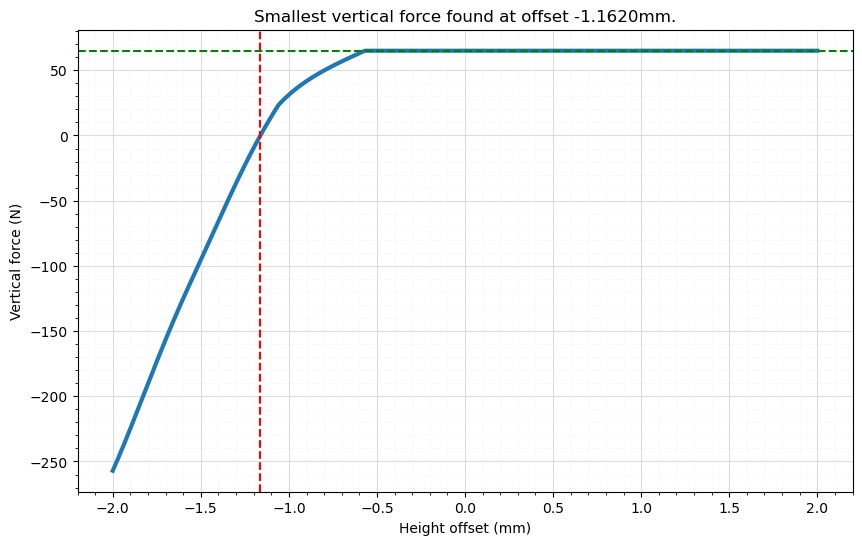

In [4]:
height_offsets = np.linspace(-0.002, 0.002, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

In [5]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [ 0.00000000e+00  0.00000000e+00 -8.29304559e-03  4.47712645e+00
  1.99419240e+00  1.19944761e+00 -1.83856192e+00  3.54142580e+00
 -8.84589952e+00  4.46654614e+00  6.78838689e-01 -4.25363545e-01
 -1.81053416e-01 -1.10397379e-02]


In [6]:
actuator_moment = np.zeros((model.nu, model.nv))
mujoco.mju_sparse2dense(
    actuator_moment,
    data.actuator_moment.reshape(-1),
    data.moment_rownnz,
    data.moment_rowadr,
    data.moment_colind.reshape(-1),
)
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

control setpoint: [-1.83856192  3.5414258  -8.84589952  0.67883869 -0.42536354 -0.18105342]


In [7]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [ 0.          0.          0.          0.          0.          0.
 -1.83856192  3.5414258  -8.84589952  0.          0.67883869 -0.42536354
 -0.18105342  0.        ]


In [ ]:
nu = model.nu  # Alias for the number of actuators.
R = np.eye(nu)
nv = model.nv

# Get the Jacobians for the left and right foot CoMs.
jac_foot_left = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot_left, None, model.body('l_foot').id)

jac_foot_right = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot_right, None, model.body('r_foot').id)

# Average the two Jacobians to approximate the Jacobian at the midpoint.
jac_foot_mid = 0.5 * (jac_foot_left + jac_foot_right)

# Get the Jacobian for the root body (torso) CoM.
jac_com = np.zeros((3, nv))
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('body').id)

# Use the difference for your balance metric.
jac_diff = jac_com - jac_foot_mid
Qbalance = jac_diff.T @ jac_diff


6


In [ ]:
# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt) if model.joint(i).name not in ["l_foot_joint", "r_foot_joint"]]

# Get indices into relevant sets of joints.
root_dofs = range(6)
body_dofs = range(6, nv)
left_leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'l' in name
    and ('hip' in name or 'knee' in name or 'arm' in name)
]
right_leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'r' in name
    and ('hip' in name or 'knee' in name or 'arm' in name)
]
balance_dofs = left_leg_dofs + right_leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)
print('root_dofs:', root_dofs)
print('body_dofs:', body_dofs)
print('left_leg_dofs:', left_leg_dofs)
print('right_leg_dofs:', right_leg_dofs)
print('balance_dofs:', balance_dofs)
print('other_dofs:', other_dofs)

root_dofs: range(0, 6)
body_dofs: range(6, 14)
left_leg_dofs: [np.int32(6), np.int32(7), np.int32(8)]
balance_dofs: [np.int32(6), np.int32(7), np.int32(8)]
other_dofs: [ 9 10 11 12 13]


In [ ]:
# Cost coefficients.
BALANCE_COST        = 1000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# Construct the Qjoint matrix.
Qjoint = np.eye(nv)
Qjoint[root_dofs, root_dofs] *= 0  # Don't penalize free joint directly.
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint

# No explicit penalty for velocities.
Q = np.block([[Qpos, np.zeros((nv, nv))],
              [np.zeros((nv, 2*nv))]])

In [11]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)

In [14]:
# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A